In [2]:
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import json

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

datapath = 'resources/globalsales.csv'

       
def to_json(datapath, year = 2021, output = 'sales'):
    
    cats = ["Furniture", "Office Supplies", "Technology"]
    subcats = [["Bookcases", "Furnishings", "Tables", "Chairs"],["Appliances", "Binders", "Envelopes", "Fasteners", "Labels", "Paper", "Storage", "Supplies", "Art"],["Accessories", "Machines", "Phones", "Copiers"]]
    markets = ["Africa", "Asia Pacific", "Europe", "LATAM", "USCA"]
    regions = [["Central Africa", "Eastern Africa", "North Africa", "Southern Africa", "Western Africa"],["Central Asia", "Eastern Asia", "Oceania", "Southeastern Asia", "Southern Asia", "Western Asia"],["Eastern Europe", "Northern Europe", "Southern Europe", "Western Europe"],["Caribbean", "Central America", "South America"],["Canada", "Central US", "Eastern US", "Southern US", "Western US"]]
    
    
    data =[]
    n1=0
    alls = 'all'
    for cat in cats:
        d={}
        d["cat"] = cat
        d["subcat"] = alls
        d["market"] = alls
        d["region"] = alls                
        d["y"] ,d["y_fcst"] ,d["MSE"], d["MAPE"] = return_forecast(datapath, year = year, output = output, cat = cat, subcat = alls, market = alls, region = alls)
        data.append(d)

        subcat_u = subcats[n1]
        n1 = n1 + 1
        for subcat in subcat_u:
            d={}
            d["cat"] = cat
            d["subcat"] = subcat
            d["market"] = alls
            d["region"] = alls
            d["y"] ,d["y_fcst"] ,d["MSE"], d["MAPE"] = return_forecast(datapath, year = year, output = output, cat = cat, subcat = subcat, market = alls, region = alls)
            data.append(d)
            for market in markets:
                d={}
                d["cat"] = cat
                d["subcat"] = subcat
                d["market"] = market
                d["region"] = alls
                d["y"] ,d["y_fcst"] ,d["MSE"], d["MAPE"] = return_forecast(datapath, year = year, output = output, cat = cat, subcat = subcat, market = market, region = alls)
                data.append(d)
                
    return data

      
def to_json_test(datapath, year = 2021, output = 'sales'):
    
    cats = ["Furniture", "Office Supplies", "Technology"]
    subcats = [["Bookcases", "Furnishings", "Tables", "Chairs"],["Appliances", "Binders", "Envelopes", "Fasteners", "Labels", "Paper", "Storage", "Supplies", "Art"],["Accessories", "Machines", "Phones", "Copiers"]]
    markets = ["Africa", "Asia Pacific", "Europe", "LATAM", "USCA"]
    regions = [["Central Africa", "Eastern Africa", "North Africa", "Southern Africa", "Western Africa"],["Central Asia", "Eastern Asia", "Oceania", "Southeastern Asia", "Southern Asia", "Western Asia"],["Eastern Europe", "Northern Europe", "Southern Europe", "Western Europe"],["Caribbean", "Central America", "South America"],["Canada", "Central US", "Eastern US", "Southern US", "Western US"]]
    
    
    data =[]
    n1=0
    alls = 'all'
    
    for cat in cats:
        d={}
        d["cat"] = cat
        d["subcat"] = alls
        d["market"] = alls
        d["region"] = alls                
        d["y"] ,d["y_fcst"] ,d["MSE"], d["MAPE"] = return_forecast(datapath, year = year, output = output, cat = cat, subcat = alls, market = alls, region = alls)
        data.append(d)

        subcat_u = subcats[n1]
        n1 = n1 + 1
        for subcat in subcat_u:
            d={}
            d["cat"] = cat
            d["subcat"] = subcat
            d["market"] = alls
            d["region"] = alls
            d["y"] ,d["y_fcst"] ,d["MSE"], d["MAPE"] = return_forecast(datapath, year = year, output = output, cat = cat, subcat = subcat, market = alls, region = alls)
            data.append(d)
            
    return data

def filterdata(df1,output='sales', cat = "all", subcat = "all", market = "all", region = "all" ):
    
    if cat != "all":
        df2 = df1[df1['cat']==cat]
    else:
        df2 = df1
    if subcat != "all":
        df3 = df2[df2['subcat']==subcat]
    else:
        df3 = df2
    if market != "all":
        df4 = df3[df3['market']==market]
    else:
        df4 = df3
    if region != "all":
        df5 = df4[df4['region']==region]
    else:
        df5 = df4
                
    df_filtered = df5.groupby(['date'], as_index = False)["{}".format(output)].sum()
    df_filtered = df_filtered.set_index('date').sort_values(by = 'date')

    return df_filtered


def to_integer(dt_time):
    return (dt_time.year-2016)*12 + dt_time.month

def clean_data(datapath, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):
    df = pd.read_csv(datapath,encoding = "ISO-8859-1")
    df.drop(df.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,25]], axis=1, inplace=True)
    df.columns =['date',"region","market","subcat","cat","sales","quantity","discount","profit","shippingcost"]
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
    df['date'] = df['date'].apply(lambda dt: dt.replace(day=1))
    df_main = df.groupby(['date','region','market','subcat','cat'], as_index = False)['sales','profit','shippingcost'].sum()
    result_df = filterdata(df_main, output=output, cat =cat, subcat =subcat, market =market, region =region)
    return result_df

def forecast_period(year):
    fcst_date = []
    for year in np.arange(2020,year+1):
        for month in np.arange(1,13):
            fcst_date.append(dt.datetime(year,month,1))
    return fcst_date

def return_forecast(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):

    result_df = clean_data(datapath, output=output, cat =cat, subcat =subcat, market =market, region =region)

    sum_2017 = result_df[result_df.index.year == 2017] .sum()
    sum_2018 = result_df[result_df.index.year == 2018] .sum()
    sum_2019 = result_df[result_df.index.year == 2019] .sum()

    growth_2018 =  sum_2018 / sum_2017
    growth_2019 =  sum_2018 / sum_2017

    Avg_growth = (growth_2018 + growth_2019)/2

    X_forecast = forecast_period(year)

    for row in X_forecast:
        result_df.loc[row] = result_df.iloc[-12] * Avg_growth

    df_diff = result_df.copy()

    df_diff['prev'] = df_diff[output].shift(1)
    df_diff['date'] = df_diff.index
    df_diff['diff'] = (df_diff[output] - df_diff['prev'])

    #create dataframe for transformation from time series to supervised
    df_supervised = df_diff.drop(['prev'],axis=1)
    #adding lags
    for inc in range(1,13):
        field_name = 'lag_' + str(inc)
        df_supervised[field_name] = df_supervised['diff'].shift(inc)

    #drop null values
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    #import MinMaxScaler and create a new dataframe for LSTM model
    df_model = df_supervised.drop([output,'date'],axis=1)

    #split train and test set
    train_set, test_set = df_model[0:-(len(X_forecast)+12)].values, df_model[-(len(X_forecast)+12):].values

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mape'])
    model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=0, shuffle=False)
    accuracy = model.evaluate(X_test, y_test, batch_size = 1)

    y_pred = model.predict(X_test,batch_size=1)
    #for multistep prediction, you need to replace X_test values with the predictions coming from t-1

    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

    #create dataframe that shows the predicted sales
    result_list = []
    dates = list(result_df[-(len(X_forecast)+13):].index)
    act_value = list(result_df[-(len(X_forecast)+13):][output])

    for index in range(0,len(pred_test_set_inverted)):
        result_dict = {}
        result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_value[index])
        result_dict['date'] = dates[index+1]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    #for multistep prediction, replace act_sales with the predicted sales

    #merge with actual sales dataframe
    df_sales_pred = pd.merge(result_df,df_result,on='date',how='left')
    df_sales_pred.iloc[-(len(X_forecast)):,1] = np.nan

    return list(df_sales_pred[output]), list(df_sales_pred['pred_value']), accuracy[0], accuracy[1]

def return_model(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all"):

    result_df = clean_data(datapath, output=output, cat =cat, subcat =subcat, market =market, region =region)

    df_diff = result_df.copy()

    df_diff['prev'] = df_diff[output].shift(1)
    df_diff['date'] = df_diff.index
    df_diff['diff'] = (df_diff[output] - df_diff['prev'])

    #create dataframe for transformation from time series to supervised
    df_supervised = df_diff.drop(['prev'],axis=1)
    #adding lags
    for inc in range(1,13):
        field_name = 'lag_' + str(inc)
        df_supervised[field_name] = df_supervised['diff'].shift(inc)

    #drop null values
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    #import MinMaxScaler and create a new dataframe for LSTM model
    df_model = df_supervised.drop([output,'date'],axis=1)

    #split train and test set
    train_set, test_set = df_model[0:-(12)].values, df_model[-(12):].values

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mape'])
    model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)
    accuracy = model.evaluate(X_test, y_test, batch_size = 1)

    y_pred = model.predict(X_test,batch_size=1)
    #for multistep prediction, you need to replace X_test values with the predictions coming from t-1

    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

    #create dataframe that shows the predicted sales
    result_list = []
    dates = list(result_df[-(13):].index)
    act_value = list(result_df[-(13):][output])

    for index in range(0,len(pred_test_set_inverted)):
        result_dict = {}
        result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_value[index])
        result_dict['date'] = dates[index+1]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    #for multistep prediction, replace act_sales with the predicted sales

    #merge with actual sales dataframe
    df_sales_pred = pd.merge(result_df,df_result,on='date',how='left')

    return list(df_sales_pred[output]), list(df_sales_pred['pred_value']), accuracy[0], accuracy[1]

Epoch 1/100
23/23 [==============================] - 0s 14ms/step - loss: 0.3434 - mape: 126.4860
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3316 - mape: 124.3119
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3185 - mape: 121.2653
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3074 - mape: 118.5483
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2976 - mape: 116.0372
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2888 - mape: 113.6149
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2805 - mape: 111.1921
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2726 - mape: 108.7123
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2651 - mape: 106.1479
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2578 - mape: 103.4966
Epoch 11/100
23/23 [========

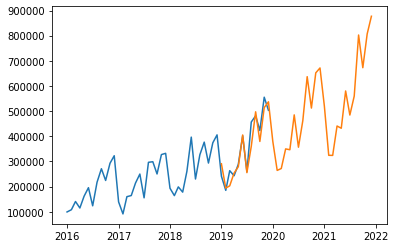

In [19]:
x, y, y_pred, mse, mape = return_forecast(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all")
plt.plot(x,y)
plt.plot(x,y_pred)
print('test loss, Mean Absolute Percentage Error(MAPE):', mse, mape)

Epoch 1/100
23/23 [==============================] - 0s 15ms/step - loss: 0.2690 - mape: 100.1543
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2579 - mape: 98.0260
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2489 - mape: 95.1752
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2404 - mape: 92.5404
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2322 - mape: 90.5832
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2243 - mape: 88.5910
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2165 - mape: 86.5569
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2090 - mape: 84.4709
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2015 - mape: 82.3236
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1941 - mape: 80.1087
Epoch 11/100
23/23 [=================

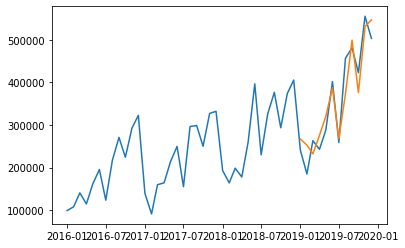

In [21]:
x, y, y_pred, mse, mape = return_model(datapath, year = 2021, output='sales', cat = "all", subcat = "all", market = "all", region = "all")
plt.plot(x,y)
plt.plot(x,y_pred)
print('test loss, Mean Absolute Percentage Error(MAPE):', mse, mape)

In [3]:
json_forecasts = to_json(datapath)   


36/36 [==============================] - 2s 66ms/step


In [ ]:
json_forecasts

In [ ]:
with open('forecastresults', 'w') as fout:
    json.dump(json_forecasts, fout)